This notebook implements a camera wrapper-style functionality with the new Source & SourcePhotometricExposure objects 

In [56]:
def uvspec_exptime(telescope, mode, template, fuvmag, snr_goal, silent=False): 
    
    ''' Run a basic SNR calculation that takes in a telescope, 
      spectral template, normalization magnitude, and SNR goal  
      to compute exposure time. For converting magnitude, template, 
      and exptime to SNR, use uvspec_snr.py 
      
        usage: 
	       wave, exptime, uvi = uvspec_exptime(telescope, mode, template, uvmag, snr_goal) 

          positional arguments:

           1-telescope = 'EAC1', 'EAC2', or 'EAC3'. This argument is a string. 
             EAC1 = 6 m inner diameter, 7.2 outer diameter hex pattern, off-axis 
             EAC2 = 6 m diameter off-axis 
             EAC3 = 8 m diameter on-axis 

           2-mode = your choice of UVI grating, a string: 
		        ['G120M', 'G150M', 'G180M', 'G155L', 'G145LL', 'G300M']

           3-template = your choice of spectral template: 
	          	['flam', 'qso', 's99', 'o5v', 'g2v', 'g191b2b', 'gd71', 'gd153', 'ctts', 
                        'mdwarf', 'orion', 'nodust', 'ebv6', 'hi1hei1', 'hi0hei1']

           4-fuvmag = FUV magnitude to normalize the template spectrum, a float. 

	         5-snr_goal = desired SNR, per pixel 

         outputs are two arrays of floats for wavelength and exptime and the Spectrograph 
		     object in case it is needed by other code. 
       '''  
    
    from syotools.models import Telescope, Spectrograph, Source, SourceSpectrographicExposure
    import astropy.units as u

    # create the basic objects 
    uvi, tel = Spectrograph(), Telescope() 
    tel.set_from_json(telescope)
    tel.add_spectrograph(uvi)
    uvi.mode = mode

    source = Source() 
    redshift = 0.0 
    extinction = 0.0 
    source.set_sed(template, fuvmag, redshift, extinction, 'galex,fuv')   

    uvi_exp = SourceSpectrographicExposure() 
    uvi_exp.source = source
    uvi_exp.verbose = True 
    uvi.add_exposure(uvi_exp) 

    uvi_exp.verbose = False 
    if (silent):  uvi_exp.verbose = False 

    if not silent: 
        print("Current SED template: {}".format(source.sed.name)) 
        print("Current grating mode: {}".format(uvi.descriptions[uvi.mode])) 
        print("Current exposure time: {} hours\n".format(uvi_exp.exptime)) 
    
    uvi_exp._snr_goal= snr_goal * (u.ct)**0.5 / (u.pix)**0.5

    snr = uvi_exp.recover('exptime')
    uvi_exp.unknown = 'exptime' #< --- this triggers the _update_exptime function in the SpectrographicExposure exposure object 

    uvi_exptime = uvi_exp.recover('exptime')

    wave, exptime =  uvi.wave, uvi_exp.exptime

    return wave, exptime, uvi 

In [57]:
wave, snr, uvi = uvspec_exptime('EAC1', 'G180M', 'Flat (AB)', 19., 1., silent=False)

Creating exposure for HWO-EAC-1 (7.2 m) with UVI in mode G180M
exptime in _update_snr 3600.0 s
SNR: [7.0548247  7.0547454  7.05464626 ... 9.13293211 9.13276366 9.13257988] ct(1/2) / pix(1/2)
Current SED template: Flat spectrum of 30 abmag * 0.999785 at z=0 * MWAvg(EBV=0) * 25118.9
Current grating mode: G180M (R = 40,800)
Current exposure time: [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'hr'] hours



In [40]:
import matplotlib.pyplot as plt

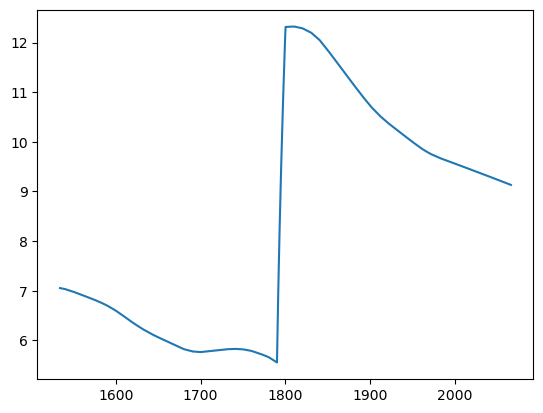

In [41]:
plt.plot(wave, snr) 